# Trust region policy optimization

## Implementation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.distributions import Normal

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ReplayBuffer:
    def __init__(self, env, policy, maxlen=10000, device="cpu"):
        self.env = env
        self.buffer = deque(maxlen=maxlen)
        self.maxlen = maxlen
        self.fill(policy)
        self.device = device

    def __len__(self):
        return len(self.buffer)

    def fill(self, policy):
        while len(self.buffer) < self.maxlen:
            state = self.env.reset()
            done = False
            while not done:
                with torch.no_grad():
                    action, log_action_prob = policy.select_action(state)
                next_state, reward, done, _ = self.env.step(action)
                self.buffer.append((state, action, log_action_prob, reward, next_state, done))
                state = next_state

    def add(self, state, action, log_action_prob, reward, next_state, done):
        self.buffer.append((state, action, log_action_prob, reward, next_state, done))

    def sample(self, n_samples):
        state, action, log_action_prob, reward, next_state, done = zip(*random.sample(self.buffer, n_samples))
        state = torch.tensor(state).float().to(self.device)
        action = torch.tensor(action).float().to(self.device)
        log_action_prob = torch.tensor(log_action_prob).float().to(self.device)
        reward = torch.tensor(reward).float().to(self.device)
        next_state = torch.tensor(next_state).float().to(self.device)
        done = torch.tensor(done).float().to(self.device)
        return state, action, log_action_prob, reward, next_state, done

In [3]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Policy, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * action_dim),
        )

    def forward(self, obs):
        ### [B, state_dim] --> [B, action_dim] * 2
        obs = torch.tensor(obs).float().to(DEVICE)
        if len(obs.shape) == 1:
            obs = obs.unsqueeze(0)
        mean, log_std = torch.chunk(self.net(obs), 2, dim=-1)
        return mean, log_std

    def select_action(self, state, action_range=1):
        try:
            state = torch.tensor(state).float()
            mean, log_std = self.forward(state)
            std = torch.exp(log_std)
            action_dist = Normal(mean, std)
            action = action_range * torch.tanh(mean + std * torch.randn_like(mean))
            action_log_prob = action_dist.log_prob(mean + std * torch.randn_like(mean)) - torch.log(1 - action.pow(2) + 1e-6)
            action_log_prob = action_log_prob.sum(-1, keepdim=True)  # Sum over action dimensions
            return action, action_log_prob
        except Exception as e:
            print(f"Exception occurred: {e}")
            if 'log_std' in locals():
                print(f"log_std: {log_std}")
            raise

class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, out_dim=1):
        super(ValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, state):
        ### [B, state_dim] --> [B, ]
        return self.net(state).squeeze(-1)

class QValueNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QValueNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state, action):
        ### [B, state_dim] + [B, ] -> [B, 1]
        if len(action.shape) == 1:
            action = action.unsqueeze(-1)
        return self.net(torch.cat([state, action], dim=-1)).squeeze(-1)

In [ ]:
class CQLAgent:
    def __init__(self, env, tau, lr=1e-3, device="cpu"):
        self.env = env
        self.state_dim, self.action_dim = env.observation_space.shape[0], 6
        self.policy = Policy(self.state_dim, self.action_dim)
        self.value = ValueNetwork(self.state_dim)
        self.target_value = ValueNetwork(self.state_dim)

        for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
            target_param.data.copy_(param.data)

        self.q_value1 = QValueNetwork(self.state_dim, self.action_dim)
        self.q_value2 = QValueNetwork(self.state_dim, self.action_dim)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=lr)
        self.q_value_optimizer1 = optim.Adam(self.q_value1.parameters(), lr=lr)
        self.q_value_optimizer2 = optim.Adam(self.q_value2.parameters(), lr=lr)

        self.policy_scheduler = torch.optim.lr_scheduler.StepLR(self.policy_optimizer, step_size=150, gamma=0.7)
        self.value_scheduler = torch.optim.lr_scheduler.StepLR(self.value_optimizer, step_size=150, gamma=0.7)
        self.q_value_scheduler1 = torch.optim.lr_scheduler.StepLR(self.q_value_optimizer1, step_size=150, gamma=0.7)
        self.q_value_scheduler2 = torch.optim.lr_scheduler.StepLR(self.q_value_optimizer2, step_size=150, gamma=0.7)

        self.buffer = ReplayBuffer(env, self.policy, maxlen=10000)
        self.tau = tau
        self.device = device

    def learn_episode(self, max_steps=10000, gamma=1, batch_size=32):
        self.policy.train()
        self.value.train()
        self.q_value1.train()
        self.q_value2.train()
        state = self.env.reset()
        done = False
        step = 0
        train_value_loss, train_q_value1_loss, train_q_value2_loss, train_policy_loss = 0, 0, 0, 0
        episode_reward = 0

        while not done and step < max_steps:
            self.policy_optimizer.zero_grad()
            self.value_optimizer.zero_grad()
            self.q_value_optimizer1.zero_grad()
            self.q_value_optimizer2.zero_grad()

            with torch.no_grad():  # Prevents gradient tracking
                action, log_action_prob = self.policy.select_action(state)
            next_state, reward, done, _ = self.env.step(action)
            episode_reward += reward
            self.buffer.add(state, action, log_action_prob, reward, next_state, done)
            state = next_state
            step += 1

            ## 0. Sample a batch
            old_states, old_actions, old_log_probs, rewards, next_states, dones = self.buffer.sample(batch_size)

            ## 1. Train value function
            with torch.no_grad():  # Prevents gradient tracking for new action values
                new_actions, new_log_probs = self.policy.select_action(old_states, evaluate=True)
                new_q_value1 = self.q_value1(old_states, new_actions)
                new_q_value2 = self.q_value2(old_states, new_actions)
                new_q_value = torch.min(new_q_value1, new_q_value2)

            value_loss = 0.5 * nn.MSELoss()((new_q_value - new_log_probs).detach(), self.value(old_states))
            value_loss.backward(retain_graph=True)
            self.value_optimizer.step()

            ## 2. Train q-value function
            with torch.no_grad():  # Prevents gradient tracking for target values
                target = rewards + gamma * self.target_value(next_states) * (1 - dones)
            old_q_value1 = self.q_value1(old_states, old_actions)
            old_q_value2 = self.q_value2(old_states, old_actions)
            q_value_loss1 = 0.5 * nn.MSELoss()(old_q_value1, target.detach())
            q_value_loss2 = 0.5 * nn.MSELoss()(old_q_value2, target.detach())
            q_value_loss1.backward(retain_graph=True)
            q_value_loss2.backward(retain_graph=True)
            self.q_value_optimizer1.step()
            self.q_value_optimizer2.step()

            ## 3. Train policy
            new_actions, new_log_probs = self.policy.select_action(old_states, evaluate=True)
            new_q_value1 = self.q_value1(old_states, new_actions)
            new_q_value2 = self.q_value2(old_states, new_actions)
            new_q_value = torch.min(new_q_value1, new_q_value2)
            policy_loss = (new_log_probs - new_q_value).mean()
            policy_loss.backward(retain_graph=True)
            self.policy_optimizer.step()

            train_value_loss += value_loss.item()
            train_q_value1_loss += q_value_loss1.item()
            train_q_value2_loss += q_value_loss2.item()
            train_policy_loss += policy_loss.item()

            ## 4. Update target value network
            for target_param, param in zip(self.target_value.parameters(), self.value.parameters()):
                target_param.data.copy_(target_param.data * (1 - self.tau) + param.data * self.tau)
        return train_value_loss / step, train_q_value1_loss / step, train_q_value2_loss / step, train_policy_loss / step, episode_reward

    def learn(self, n_episodes, max_steps=10000, gamma=1):
        history = {"value_loss": [], "q_value1_loss": [], "q_value2_loss": [], "policy_loss": [], "reward": []}
        for episode in range(n_episodes):
            value_loss, q_value1_loss, q_value2_loss, policy_loss, reward = self.learn_episode(max_steps, gamma)
            history["value_loss"].append(value_loss)
            history["q_value1_loss"].append(q_value1_loss)
            history["q_value2_loss"].append(q_value2_loss)
            history["policy_loss"].append(policy_loss)
            history["reward"].append(reward)
            print(f'Episode {episode}: loss: {(value_loss, q_value1_loss, q_value2_loss, policy_loss)}, reward {reward}') if episode % 10 == 0 else None
        return history

In [ ]:
env = gym.make("InvertedPendulumBulletEnv-v0")
agent = SoftActorCriticAgent(env, lr=1e-9, tau=0.005)
history = agent.learn(50, gamma=0.99, max_steps=2000)

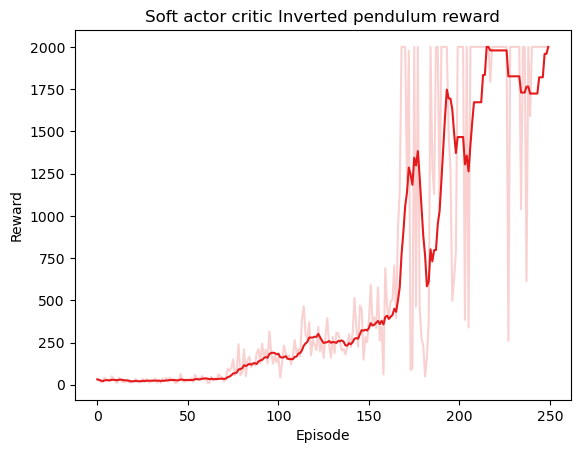

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/sac/reward.npy")]

colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward, c=colors[i], alpha=0.2)
    plt.plot(smooth(reward, 10), c=colors[i])
plt.title("Soft actor critic Inverted pendulum reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()